In [2]:
import pandas as pd
import numpy as np
import gensim
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt


In [19]:
#emb = gensim.models.doc2vec.Doc2Vec.load('../models/party_lvl-dm-m-d20-n5-w10-mc5-s0.001-t8.mdl')
emb2 = gensim.models.doc2vec.Doc2Vec.load(
    '../models/party_lvl-dm-m-d20-n5-w10-mc5-s0.001-t8-e10-bigrams-2tags-2.mdl')


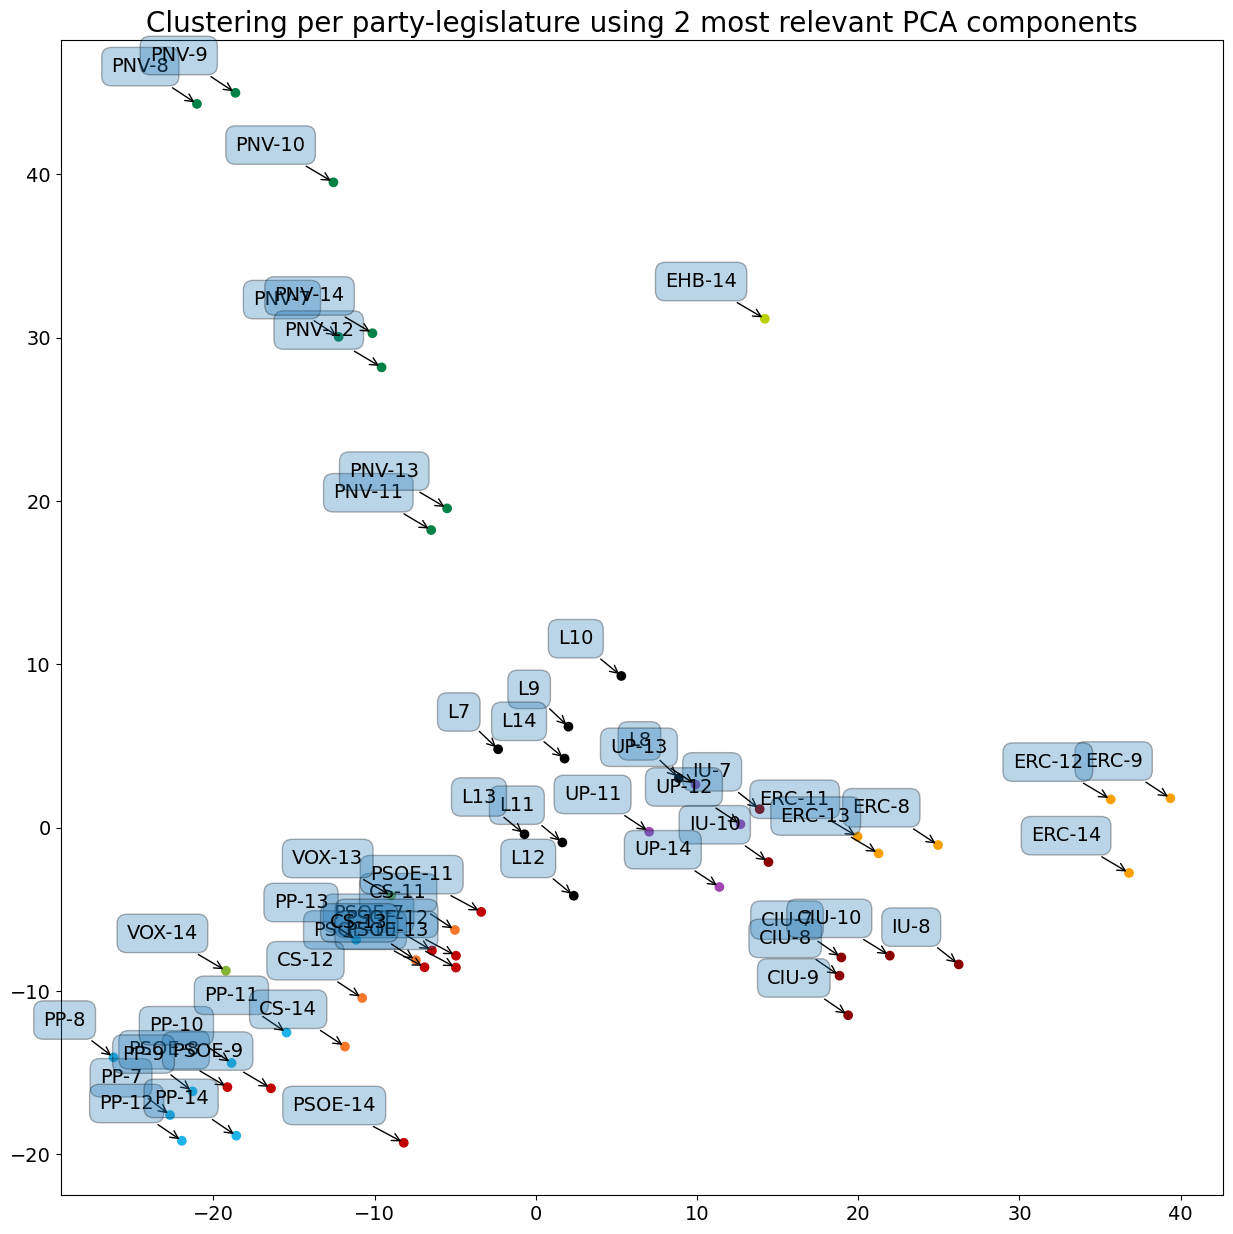

In [22]:
def reduce_dimension(model, n=2):
    speakers = [item for item in model.dv.index_to_key] # if '-' in item]
    S = len(speakers)
    M = model.vector_size
    z = np.zeros((S, M))

    for i in range(S):
        z[i, :] = model.dv[i]

    dr = PCA(n_components=n)
    Z = dr.fit_transform(z)

    Z = pd.DataFrame(Z)

    columns = []
    for i in range(n):
        columns.append(f'dim{i}')
    Z.columns = columns

    Z['speaker'] = speakers

    return Z, dr

def get_color(reduced):
    spk = reduced.speaker.tolist()
    col = []
    for i in range(len(spk)):
        if 'VOX' in spk[i]:
            # #82b431
            # rgba(130,180,49,255)
            col.append('#82b431')
        elif 'PSOE' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#c10200')
        elif 'IU' in spk[i]:
            # #c10200
            # rgba(193,2,0,255)
            col.append('#8b0000')
        elif 'CS' in spk[i]:
            # #f87729
            # rgba(248,119,41,255)
            col.append('#f87729')
        elif 'PP' in spk[i]:
            # #1eb3e6
            # rgba(30,179,230,255)
            col.append('#1eb3e6')
        elif 'UP' in spk[i]:
            # #a245b2
            # rgba(162,69,178,255)
            col.append('#a245b2')
        elif 'ERC' in spk[i]:
            # #f99f00
            # rgba(249,159,0,255)
            col.append('#f99f00')
        elif 'PNV' in spk[i]:
            # #008146
            # rgba(0,129,70,255)
            col.append('#008146')
        elif 'EHB' in spk[i]:
            # #bbce00
            # rgba(187,206,0,255)
            col.append('#bbce00')
        else:
            col.append('#000000')

    reduced['col'] = col
    return reduced

def plot(reduced):
    mpl.rcParams['axes.titlesize'] = 20
    mpl.rcParams['axes.labelsize'] = 20
    mpl.rcParams['font.size'] = 14

    plt.figure(figsize=(15, 15))
    plt.scatter(reduced.dim0, reduced.dim1, c=reduced.col)
    texts = []

    for label, x, y in zip(reduced.speaker, reduced.dim0, reduced.dim1):
        plt.annotate(
            label,
            xy=(x, y), xytext=(-20, 20),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', alpha=0.3),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

    plt.title(
        'Clustering per party-legislature using 2 most relevant PCA components')
    plt.show()

Z, dr = reduce_dimension(emb2)
reduced = get_color(Z)
plot(reduced)


In [23]:
def interpret(emb, pca, N, min_count, max_count, topn) -> list:
    
    # List all the tokens sorted by ocurrence in the corpus.
    words = emb.wv.index_to_key

    max = reduced.max()
    min = reduced.min()

    wl = []
    for w in words:
        wl.append((w, emb.wv.get_vecattr(w, 'count')))
    
    selected_wl = [word for word, c in wl if c > min_count and c < max_count]

    if len(selected_wl) < N:
        N = len(selected_wl)
        print(f'Size of selected_wl is smaller than N. N is now = {N}')

    selected_wl = selected_wl[0:N]

    # Reduce the vectors for each selected word using the PCA model to a 2D vector.
    M = np.zeros((N, 2))
    for i, w in enumerate(selected_wl):
        M[i, :] = pca.transform(emb.wv[w].reshape(1, -1))

    # Compute euclidean distances to each corner of the reduced embedding space.
    right = euclidean_distances(M, np.array([max[0], 0]).reshape(1, -1))
    left = euclidean_distances(M, np.array([min[0], 0]).reshape(1, -1))
    up = euclidean_distances(M, np.array([0, max[1]]).reshape(1, -1))
    down = euclidean_distances(M, np.array([0, min[1]]).reshape(1, -1))

    similarities = pd.DataFrame({
        'word': selected_wl,
        'right': right[:, 0],
        'left': left[:, 0],
        'up': up[:, 0],
        'down': down[:, 0]})

    print('Words associated with possitive values of the first PCA component (right):')
    print(80*'-')
    print(similarities.sort_values(by='right')['word'].tolist()[0:topn])
    print('\n')

    print('Words associated with negative values of the first PCA component (left):')
    print(80*'-')
    print(similarities.sort_values(by='left')['word'].tolist()[0:topn])
    print('\n')

    print('Words associated with possitive values of the second PCA component (up):')
    print(80*'-')
    print(similarities.sort_values(by='up')['word'].tolist()[0:topn])
    print('\n')

    print('Words associated with negative values of the second PCA component (down):')
    print(80*'-')
    print(similarities.sort_values(by='down')['word'].tolist()[0:topn])
    print('\n')

interpret(emb2, dr, 10000, 200, 10000, 50)

Words associated with possitive values of the first PCA component (right):
--------------------------------------------------------------------------------
['catalunya', 'parlament_catalunya', 'generalitat', 'generalitat_catalunya', 'esquerra_republicana', 'estatut', 'tarragona', 'izquierdas', 'planteábamos', 'barcelona', 'lleida', 'catalana', 'ión_permanente_mbre_pág', 'generalitat_cataluña', 'planteamos', 'girona', 'aeropuerto_prat', 'ayuntamiento_barcelona', 'cercanías', 'ciudad_barcelona', 'país_valencià', 'republicano', 'catalán', 'represión', 'continúa_siendo', 'ambiental', 'catalanes', 'catalanas', 'esquerra', 'republicanos', 'entendíamos', 'cambio_modelo', 'grandes_fortunas', 'prat', 'economía_productiva', 'país_valenciano', 'israel', 'pobreza_energética', 'illes_balears', 'csn', 'parlament', 'sociedad_catalana', 'reclamamos', 'sociedad_civil', 'amnistía_internacional', 'traspaso', 'estatuto_autonomía_cataluña', 'avanzar_hacia', 'izquierda_unida_catalunya', 'óptica']


Words as

In [24]:
#s = ['empresas', 'libertad', 'beneficios', 'privado']
s = ['ultraizquierda']
infer_vector = emb2.infer_vector(s)
similar_documents = emb2.dv.most_similar([infer_vector], topn=10)
similar_documents


[('L13', 0.36505576968193054),
 ('L14', 0.35722580552101135),
 ('L9', 0.3246925175189972),
 ('L11', 0.26970911026000977),
 ('L10', 0.24622660875320435),
 ('L12', 0.23163193464279175),
 ('L8', 0.2081340253353119),
 ('CS-13', 0.1763000339269638),
 ('PNV-7', 0.16644524037837982),
 ('PNV-11', 0.1657649427652359)]

In [34]:
emb2.wv.similar_by_vector(
    emb2.dv['PSOE-9'], topn=100, restrict_vocab=20000)

[('pronuncia_palabras_perciben', 0.6248763203620911),
 ('duda_alguna', 0.5863289833068848),
 ('conocen', 0.5773627161979675),
 ('teléf_fax', 0.5766459703445435),
 ('http_www', 0.5656652450561523),
 ('edita_calle_floridablanca_madrid', 0.5617567300796509),
 ('quiero_decirles', 0.5511251091957092),
 ('boe_avenida_manoteras_madrid', 0.5475951433181763),
 ('pide_palabra', 0.5375739336013794),
 ('primera_vez', 0.5338374376296997),
 ('rumores', 0.5256921052932739),
 ('supuesto', 0.5136711001396179),
 ('afortunadamente', 0.505327582359314),
 ('cabe_duda', 0.49638479948043823),
 ('poniendo_marcha', 0.4935041069984436),
 ('continúan_rumores', 0.492647647857666),
 ('trabajando', 0.4913296699523926),
 ('mejorando', 0.48940396308898926),
 ('diré', 0.4889146089553833),
 ('seguir_trabajando', 0.48682844638824463),
 ('primera_intervención', 0.4816477596759796),
 ('gamarra', 0.47644415497779846),
 ('desarrollando', 0.4669719934463501),
 ('gestos_negativos', 0.4560961127281189),
 ('destacar', 0.4556125